In [502]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import calendar
from math import sqrt
import plotly.express as px
from scipy.stats import boxcox
import plotly.graph_objects as go
from pandas.plotting import lag_plot
import statsmodels.formula.api as smf 
from plotly.subplots import make_subplots
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import warnings
warnings.filterwarnings('ignore')

In [503]:
#Loading the dataset
df = pd.read_csv('CocaCola_Sales_Rawdata.csv')
df.head(10)

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996
5,Q2_87,2104.411995
6,Q3_87,2014.362999
7,Q4_87,1991.746998
8,Q1_88,1869.049999
9,Q2_88,2313.631996


In [504]:
#EDA
df.isnull().sum()

Quarter    0
Sales      0
dtype: int64

In [505]:
df.shape

(42, 2)

In [506]:
df.dtypes

Quarter     object
Sales      float64
dtype: object

In [507]:
df.nunique()

Quarter    42
Sales      42
dtype: int64

In [508]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Quarter  42 non-null     object 
 1   Sales    42 non-null     float64
dtypes: float64(1), object(1)
memory usage: 804.0+ bytes


In [509]:
df.describe()

,Sales
count,42.000000
mean,2994.353308
std,977.930896
min,1547.818996
25%,2159.714247
50%,2782.376999
75%,3609.250000
max,5253.000000


### Feature Engineering
#### Converting the Quarters into Years

In [510]:
# Feature Engineering
# Converting the Quarters into Years
df['Quarter_Year'] = df['Quarter'].str.split('_').apply(lambda x: ' 19'.join(x[:]))
#Clean way to convert quarterly periods to datetime in pandas
df.head(10)

,Quarter,Sales,Quarter_Year
0,Q1_86,1734.827000,Q1 1986
1,Q2_86,2244.960999,Q2 1986
2,Q3_86,2533.804993,Q3 1986
3,Q4_86,2154.962997,Q4 1986
4,Q1_87,1547.818996,Q1 1987
5,Q2_87,2104.411995,Q2 1987
6,Q3_87,2014.362999,Q3 1987
7,Q4_87,1991.746998,Q4 1987
8,Q1_88,1869.049999,Q1 1988
9,Q2_88,2313.631996,Q2 1988


In [511]:
# Converting into datetime formate as the index was not in correct formate.
df['Date'] = (pd.to_datetime(df['Quarter_Year'].str.split(' ').apply(lambda x: ''.join(x[::-1])),dayfirst=True))
df.head(10)

,Quarter,Sales,Quarter_Year,Date
0,Q1_86,1734.827000,Q1 1986,1986-01-01
1,Q2_86,2244.960999,Q2 1986,1986-04-01
2,Q3_86,2533.804993,Q3 1986,1986-07-01
3,Q4_86,2154.962997,Q4 1986,1986-10-01
4,Q1_87,1547.818996,Q1 1987,1987-01-01
5,Q2_87,2104.411995,Q2 1987,1987-04-01
6,Q3_87,2014.362999,Q3 1987,1987-07-01
7,Q4_87,1991.746998,Q4 1987,1987-10-01
8,Q1_88,1869.049999,Q1 1988,1988-01-01
9,Q2_88,2313.631996,Q2 1988,1988-04-01


In [512]:
# Extracting the Quarters and putting in column
df['Quarters'] = 0

for i in range(42):
    n = df['Quarter'][i]
    df['Quarters'][i] = n[0:2]
    
df.head(10)

,Quarter,Sales,Quarter_Year,Date,Quarters
0,Q1_86,1734.827000,Q1 1986,1986-01-01,Q1
1,Q2_86,2244.960999,Q2 1986,1986-04-01,Q2
2,Q3_86,2533.804993,Q3 1986,1986-07-01,Q3
3,Q4_86,2154.962997,Q4 1986,1986-10-01,Q4
4,Q1_87,1547.818996,Q1 1987,1987-01-01,Q1
5,Q2_87,2104.411995,Q2 1987,1987-04-01,Q2
6,Q3_87,2014.362999,Q3 1987,1987-07-01,Q3
7,Q4_87,1991.746998,Q4 1987,1987-10-01,Q4
8,Q1_88,1869.049999,Q1 1988,1988-01-01,Q1
9,Q2_88,2313.631996,Q2 1988,1988-04-01,Q2


In [513]:
# Creating Dummy Variables for Quarters Variable
dummy = pd.DataFrame(pd.get_dummies(df['Quarters']))
df1 = pd.concat((df, dummy), axis=1)

df1.head()

,Quarter,Sales,Quarter_Year,Date,Quarters,Q1,Q2,Q3,Q4
0,Q1_86,1734.827000,Q1 1986,1986-01-01,Q1,True,False,False,False
1,Q2_86,2244.960999,Q2 1986,1986-04-01,Q2,False,True,False,False
2,Q3_86,2533.804993,Q3 1986,1986-07-01,Q3,False,False,True,False
3,Q4_86,2154.962997,Q4 1986,1986-10-01,Q4,False,False,False,True
4,Q1_87,1547.818996,Q1 1987,1987-01-01,Q1,True,False,False,False


In [514]:
df1.drop(['Quarter','Quarter_Year'] , axis =1, inplace = True)
df1.head()

,Sales,Date,Quarters,Q1,Q2,Q3,Q4
0,1734.827000,1986-01-01,Q1,True,False,False,False
1,2244.960999,1986-04-01,Q2,False,True,False,False
2,2533.804993,1986-07-01,Q3,False,False,True,False
3,2154.962997,1986-10-01,Q4,False,False,False,True
4,1547.818996,1987-01-01,Q1,True,False,False,False


In [515]:
df1.set_index('Date',inplace=True)
df1.index.year

Index([1986, 1986, 1986, 1986, 1987, 1987, 1987, 1987, 1988, 1988, 1988, 1988,
       1989, 1989, 1989, 1989, 1990, 1990, 1990, 1990, 1991, 1991, 1991, 1991,
       1992, 1992, 1992, 1992, 1993, 1993, 1993, 1993, 1994, 1994, 1994, 1994,
       1995, 1995, 1995, 1995, 1996, 1996],
      dtype='int32', name='Date')

In [516]:
df1.head()

,Sales,Quarters,Q1,Q2,Q3,Q4
Date,,,,,,
1986-01-01,1734.827000,Q1,True,False,False,False
1986-04-01,2244.960999,Q2,False,True,False,False
1986-07-01,2533.804993,Q3,False,False,True,False
1986-10-01,2154.962997,Q4,False,False,False,True
1987-01-01,1547.818996,Q1,True,False,False,False


In [517]:
df["Date"] = pd.to_datetime(df.Date,format="%b-%y")
df["month"] = df.Date.dt.strftime("%b") # month extraction
df["year"] = df.Date.dt.strftime("%Y") # year extraction
df.head(10)

,Quarter,Sales,Quarter_Year,Date,Quarters,month,year
0,Q1_86,1734.827000,Q1 1986,1986-01-01,Q1,Jan,1986
1,Q2_86,2244.960999,Q2 1986,1986-04-01,Q2,Apr,1986
2,Q3_86,2533.804993,Q3 1986,1986-07-01,Q3,Jul,1986
3,Q4_86,2154.962997,Q4 1986,1986-10-01,Q4,Oct,1986
4,Q1_87,1547.818996,Q1 1987,1987-01-01,Q1,Jan,1987
5,Q2_87,2104.411995,Q2 1987,1987-04-01,Q2,Apr,1987
6,Q3_87,2014.362999,Q3 1987,1987-07-01,Q3,Jul,1987
7,Q4_87,1991.746998,Q4 1987,1987-10-01,Q4,Oct,1987
8,Q1_88,1869.049999,Q1 1988,1988-01-01,Q1,Jan,1988
9,Q2_88,2313.631996,Q2 1988,1988-04-01,Q2,Apr,1988


## Data Visualization

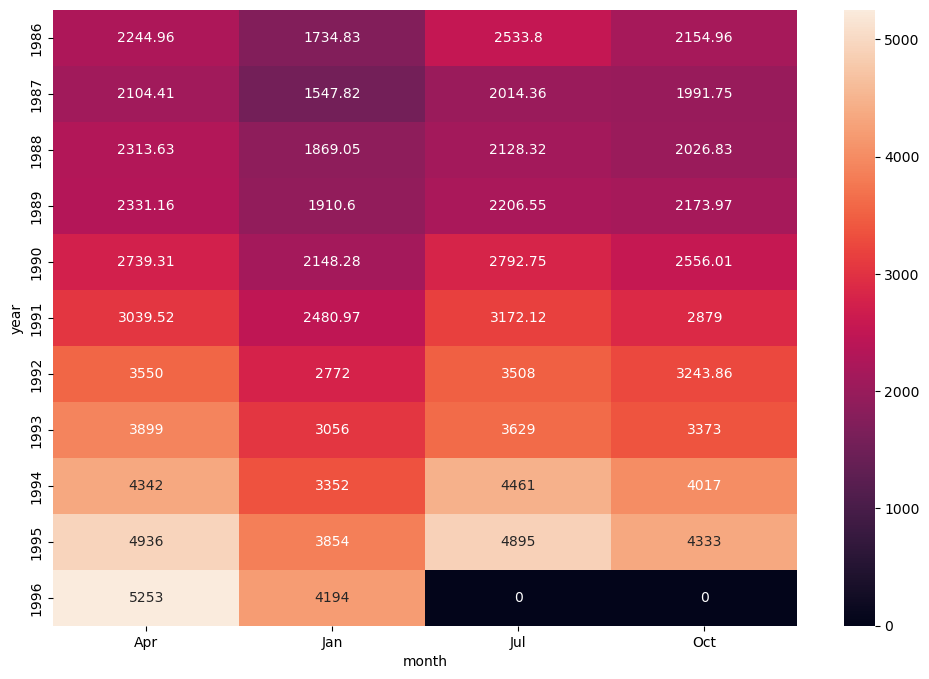

In [518]:
plt.figure(figsize=(12,8))
heatmap_y_month = pd.pivot_table(data=df, values="Sales", index="year", columns="month", aggfunc="mean", fill_value=0)
sns.heatmap(heatmap_y_month, annot=True, fmt="g")
plt.show()

### Line plot

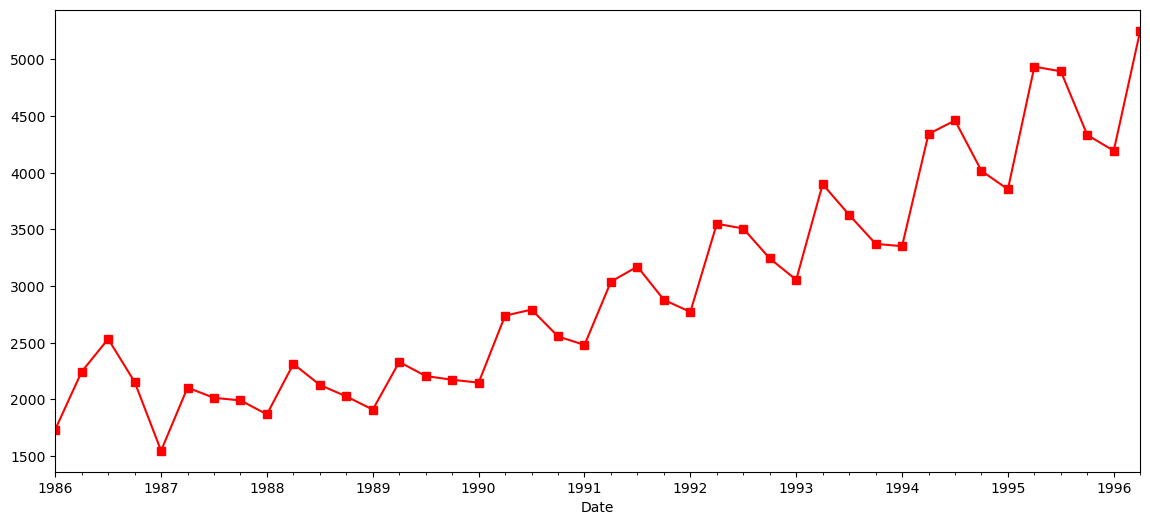

In [519]:
df1['Sales'].plot(figsize=(14,6), color='red', marker='s')
plt.show()

### Line Plot Using Quarters as Y axis and Sales as X axis

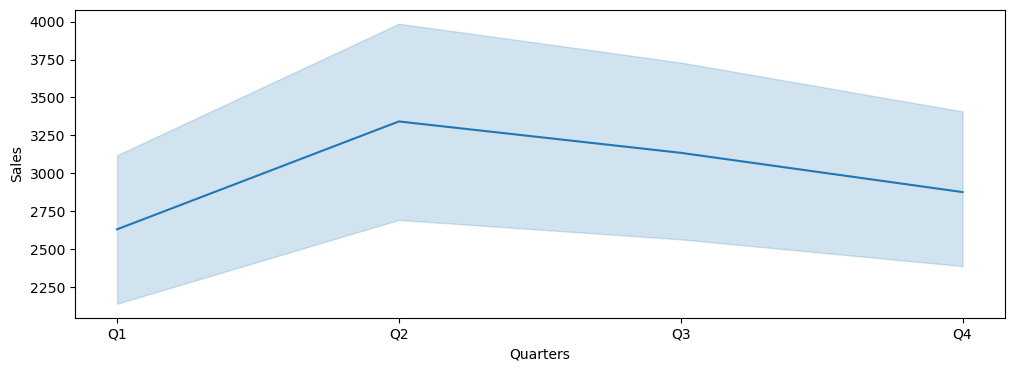

In [520]:
plt.figure(figsize=(12,4))
sns.lineplot(x="Quarters", y="Sales", data=df)
plt.show()

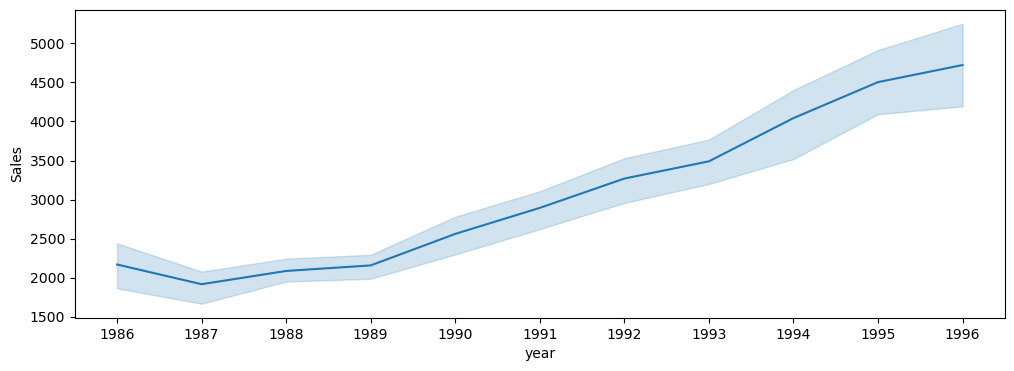

In [521]:
plt.figure(figsize=(12,4))
sns.lineplot(x="year",y="Sales",data=df)
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

### Histogram and Density Plots

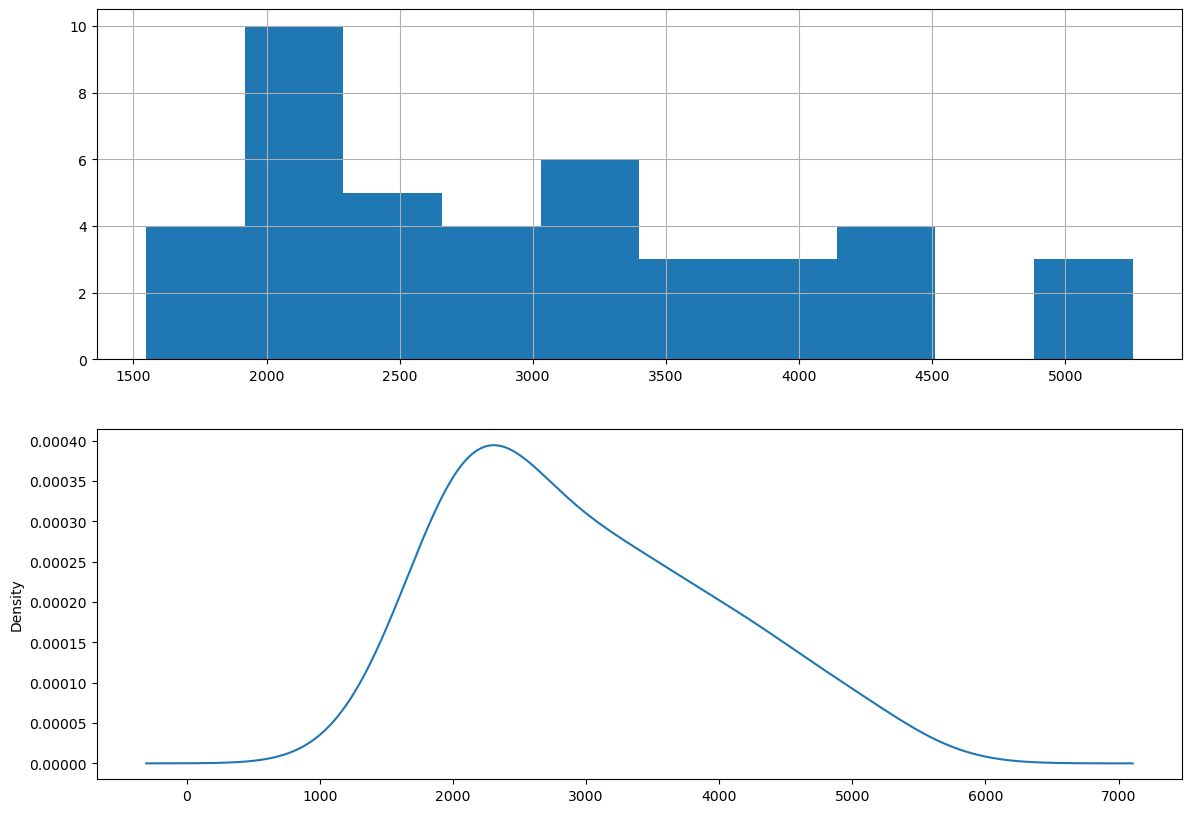

In [522]:
plt.figure(figsize=(14,10))
plt.subplot(211)
df.Sales.hist()
plt.subplot(212)
df.Sales.plot(kind='kde')
plt.show()

### Lag plot

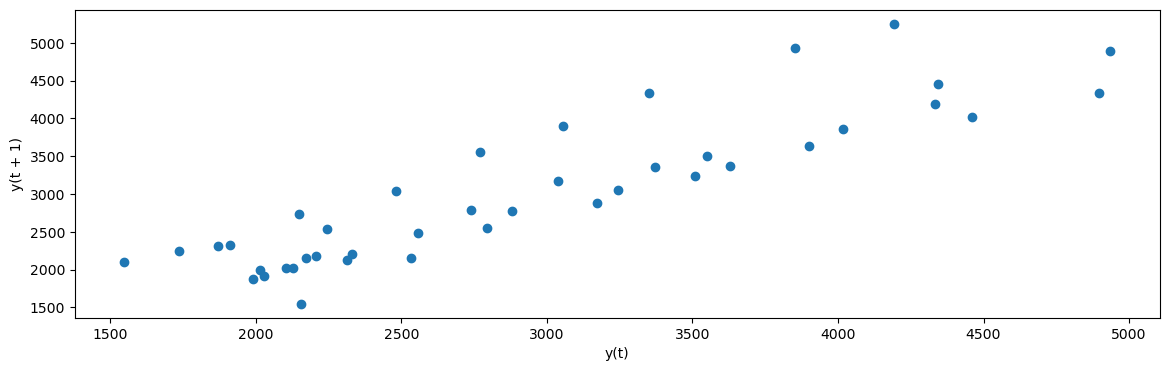

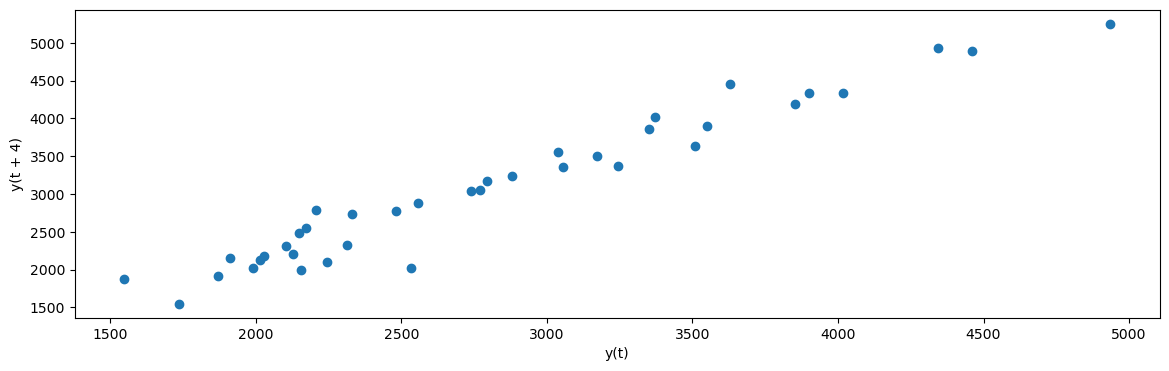

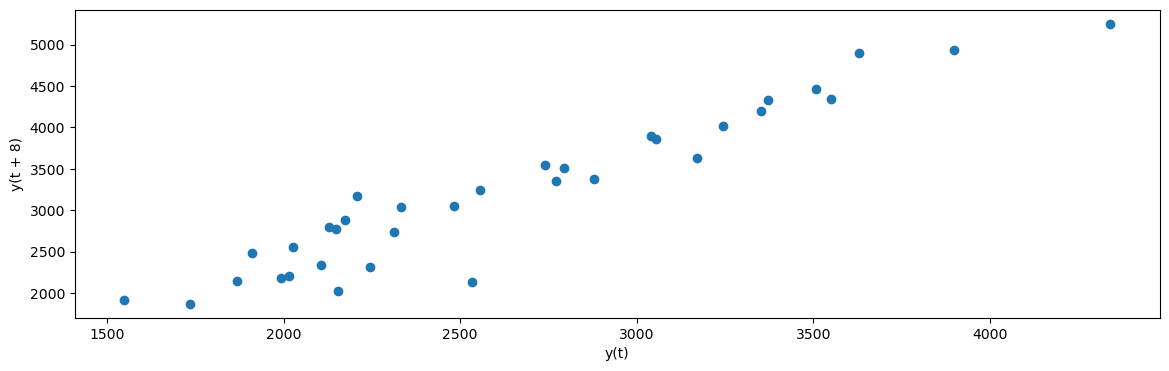

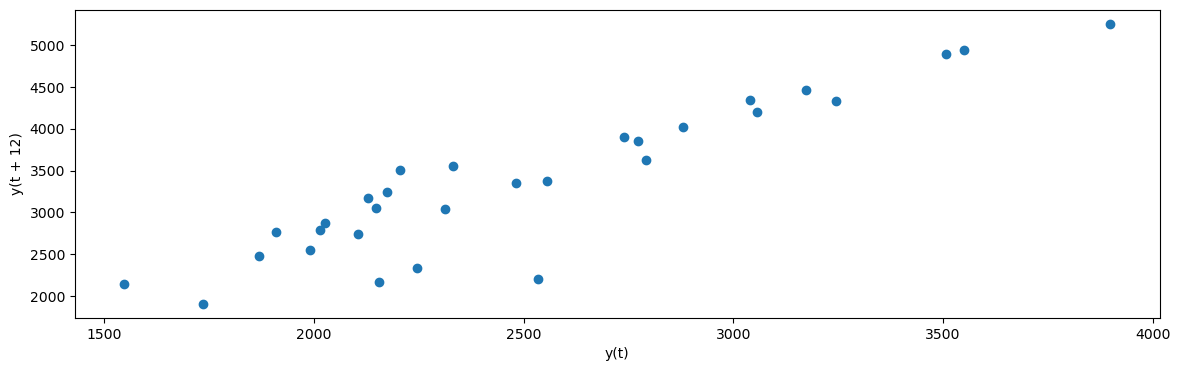

In [523]:
# create a scatter plot
for i in [1, 4, 8, 12]:
    lag_plot(df.Sales, lag=i)
    plt.show()

### Moving Average

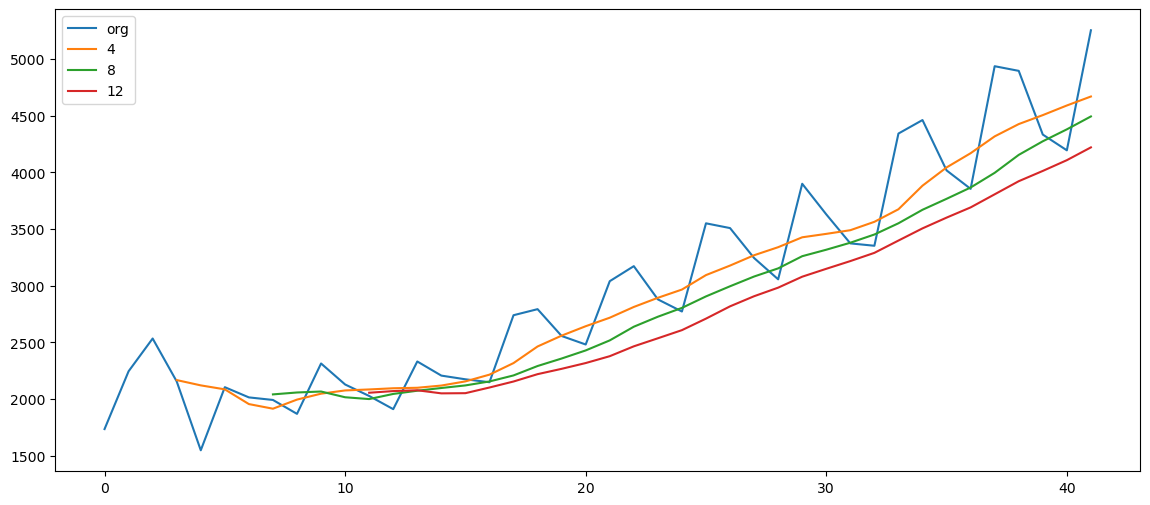

In [524]:
plt.figure(figsize=(14,6))
df.Sales.plot(label="org")
for i in range(4,13,4):
    df["Sales"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

## ACF plots and PACF plots
### Autocorrelation Function (ACF)

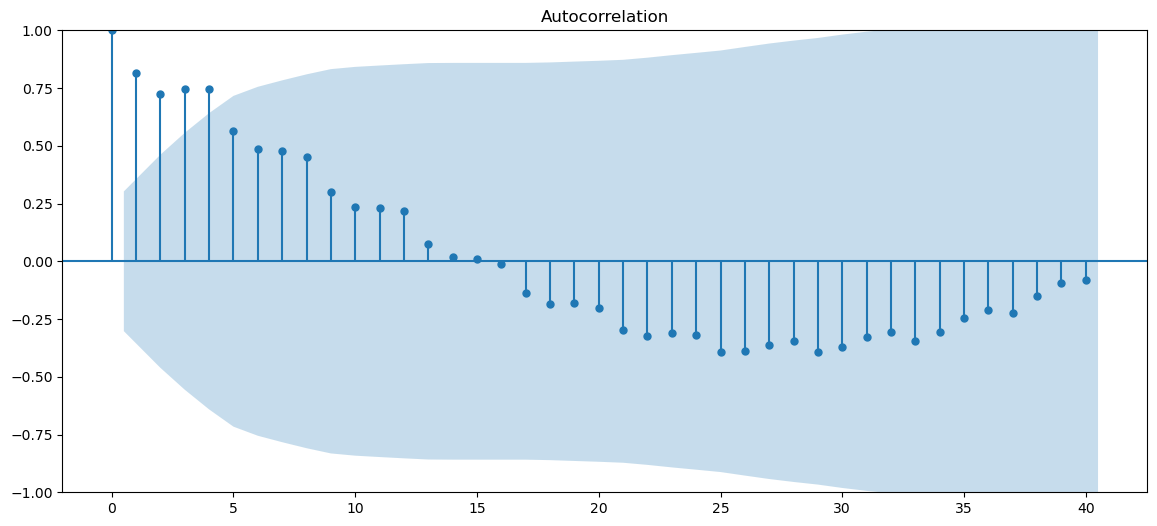

In [525]:
import statsmodels.graphics.tsaplots as tsa_plots
with plt.rc_context():
    plt.rc("figure", figsize=(14,6))
    tsa_plots.plot_acf(df.Sales,lags=40)
    plt.show()

#### Autocorrelation is the correlation between a time series (signal) and a delayed version of itself, while the ACF plots the correlation coefficient against the lag, and it’s a visual representation of autocorrelation

### Partial Autocorrelation Function (PACF)

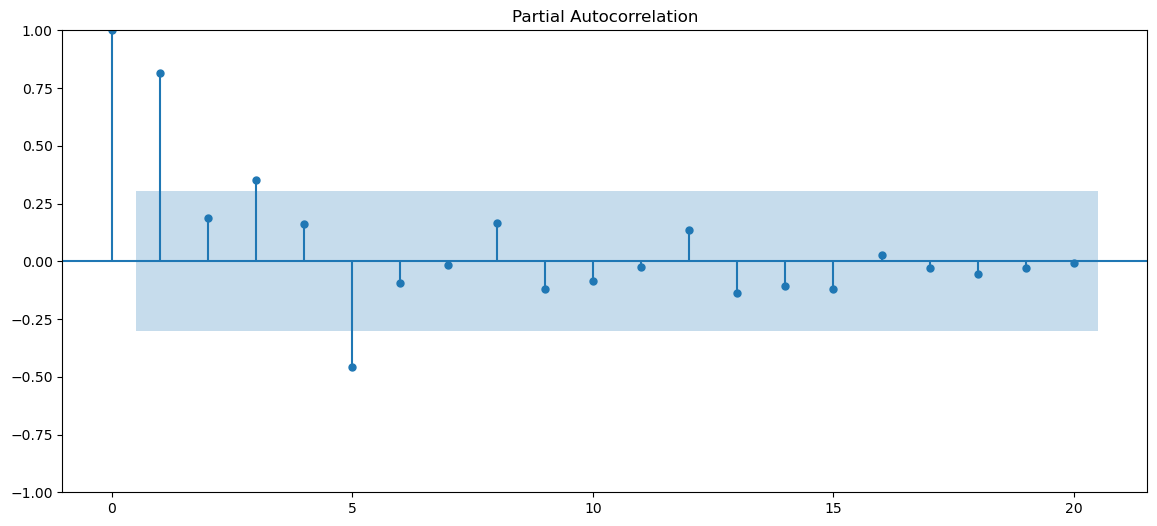

In [526]:
import statsmodels.graphics.tsaplots as tsa_plots
with plt.rc_context():
    plt.rc("figure", figsize=(14,6))
    tsa_plots.plot_pacf(df.Sales,lags=20)
    plt.show()

#### A partial autocorrelation function captures a “direct” correlation between time series and a lagged version of itself.

## Sampling
### Linear interpolation
### UpSampling with respect to month

In [527]:
upsampled_month = df1.drop(['Quarters','Q1','Q2','Q3','Q4'], axis=1)
upsampled_month = upsampled_month.resample('M').mean()
print(upsampled_month.head(13))

                  Sales
Date                   
1986-01-31  1734.827000
1986-02-28          NaN
1986-03-31          NaN
1986-04-30  2244.960999
1986-05-31          NaN
1986-06-30          NaN
1986-07-31  2533.804993
1986-08-31          NaN
1986-09-30          NaN
1986-10-31  2154.962997
1986-11-30          NaN
1986-12-31          NaN
1987-01-31  1547.818996


                  Sales
Date                   
1986-01-31  1734.827000
1986-02-28  1904.871666
1986-03-31  2074.916333
1986-04-30  2244.960999
1986-05-31  2341.242330
1986-06-30  2437.523662
1986-07-31  2533.804993
1986-08-31  2407.524328
1986-09-30  2281.243662
1986-10-31  2154.962997
1986-11-30  1952.581663
1986-12-31  1750.200330
1987-01-31  1547.818996


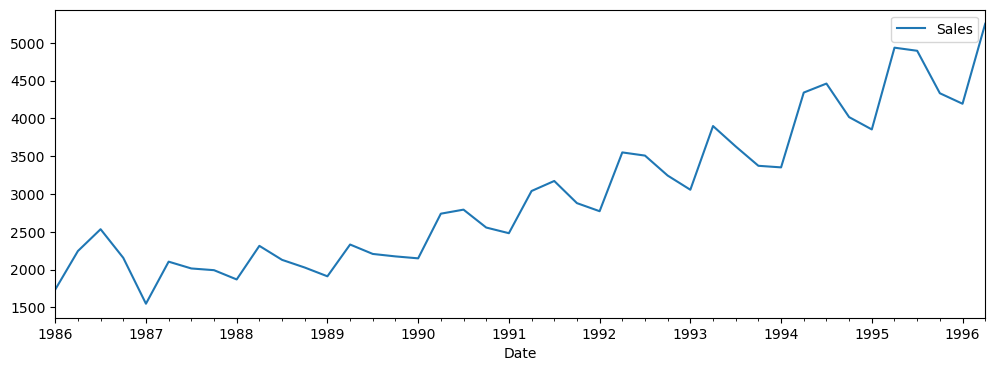

In [528]:
interpolated_month = upsampled_month.interpolate(method='linear')
print(interpolated_month.head(13))
interpolated_month.plot(figsize=(12,4))
plt.show()

## Time Series Decomposition
### 1. Seasonality
### 2. Trend

### Additive Seasonal Decomposition

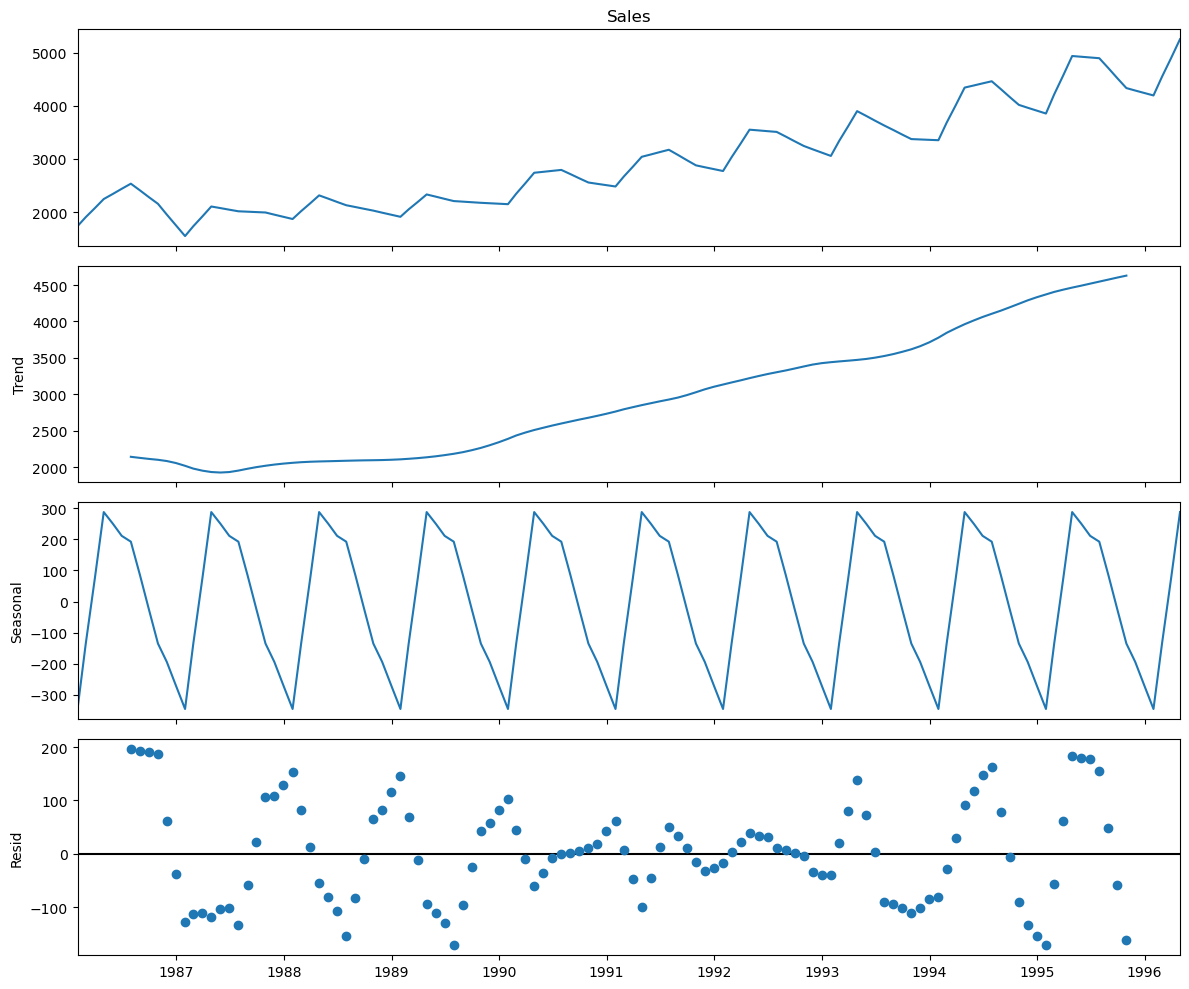

In [529]:
decompose_ts_add = seasonal_decompose(interpolated_month.Sales, period=12, model='additive')
with plt.rc_context():
    plt.rc("figure", figsize=(12,10))
    decompose_ts_add.plot()
    plt.show()

### Multiplicative Seasonal Decomposition

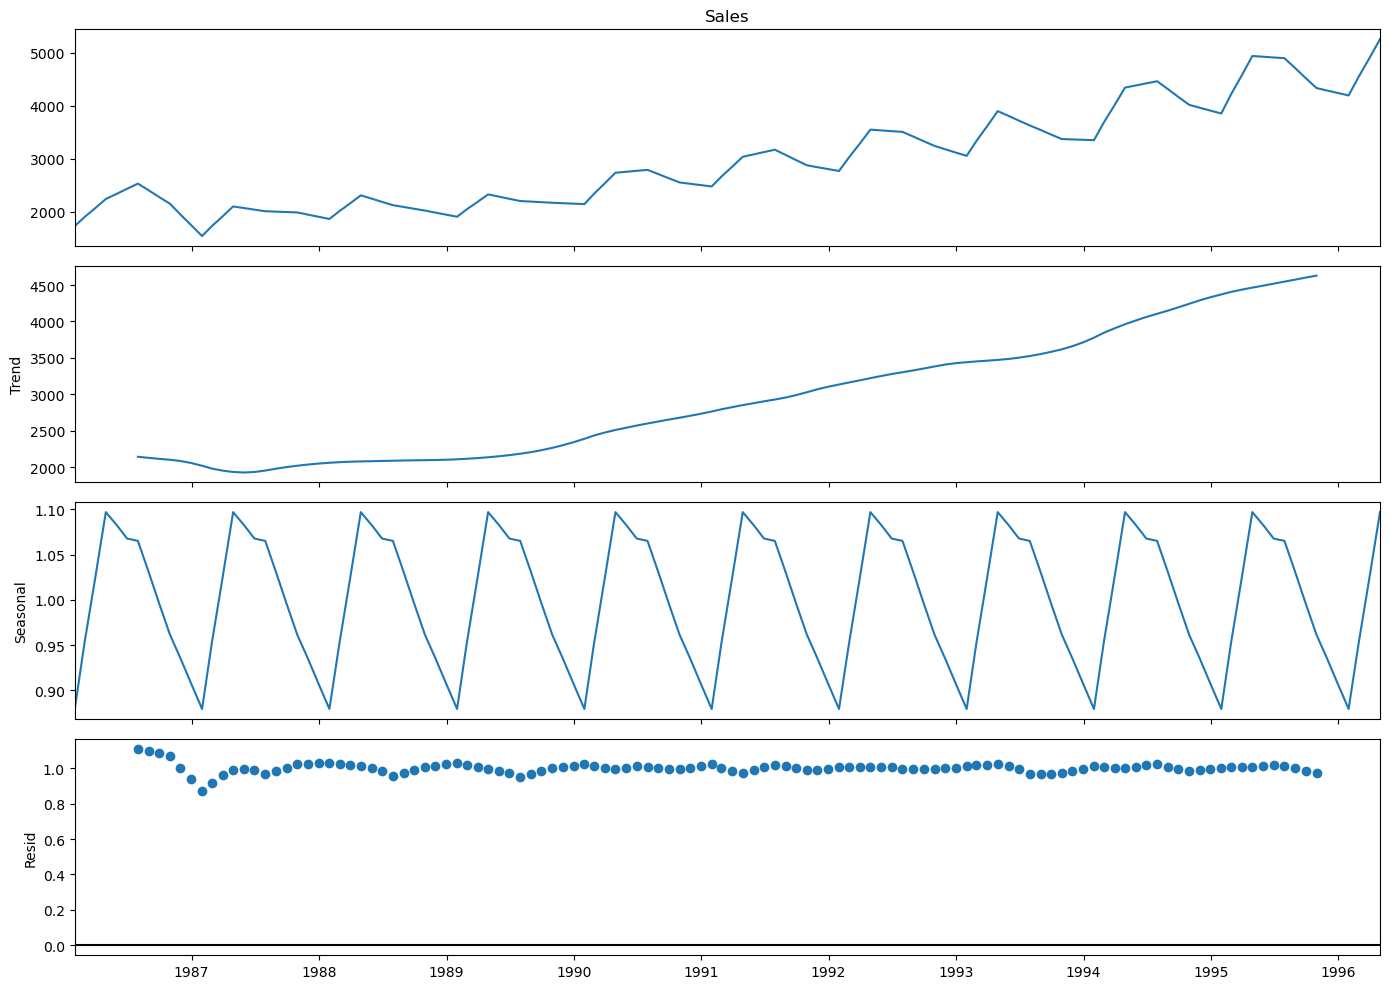

In [530]:
decompose_ts_add = seasonal_decompose(interpolated_month.Sales, period=12, model='multiplicative')
with plt.rc_context():
    plt.rc("figure", figsize=(14,10))
    decompose_ts_add.plot()
    plt.show()

### Splitting Train and Test Data
#### Leaving Test Data with 2 Years of Time Series

In [531]:
train_data = interpolated_month[:100]
test_data = interpolated_month[100:]

In [532]:
print('Train :',train_data.index.min(),train_data.index.max(),'\n',
'Test :',test_data.index.min(),test_data.index.max())

Train : 1986-01-31 00:00:00 1994-04-30 00:00:00 
 Test : 1994-05-31 00:00:00 1996-04-30 00:00:00


### Evaluation Metric MAPE

In [533]:
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

## Autoregressive Integrated Moving Averages (ARIMA)

In [534]:
def test_stationarity(timeseries):
    
    # Determine rolling statistics
    movingAverage = timeseries.rolling(window=4).mean()
    movingSTD = timeseries.rolling(window=4).std()
    
    # Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show(block=False)
    
    # Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['Sales'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

### Augmented Dicky Fuller Test

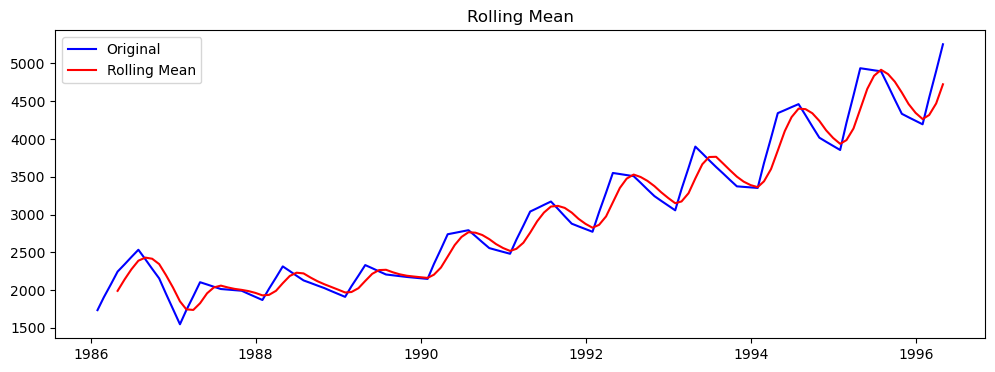

Results of Dickey Fuller Test:
Test Statistic                   0.572599
p-value                          0.986920
#Lags Used                      10.000000
Number of Observations Used    113.000000
Critical Value (1%)             -3.489590
Critical Value (5%)             -2.887477
Critical Value (10%)            -2.580604
dtype: float64


In [535]:
plt.figure(figsize=(12,4))
sales= pd.DataFrame()
sales['Sales'] = interpolated_month[['Sales']]
test_stationarity(sales)

In [536]:
def adf_test(series):    
    result = adfuller(series.dropna())  
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    if result[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [537]:
adf_test(sales.Sales)

Fail to reject the null hypothesis
Data is non-stationary


### Feature Scaling (Transformations)
### 1. Square Root Transform

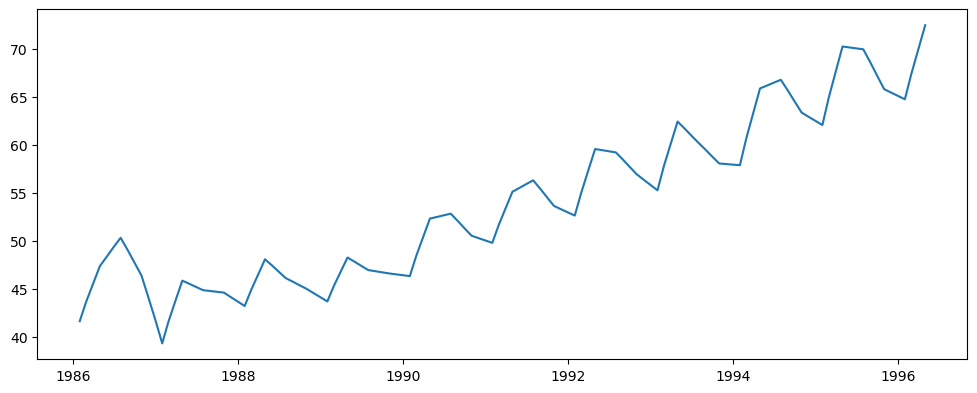

In [538]:
square_root = pd.DataFrame()
square_root = interpolated_month[['Sales']]
square_root['Sales'] = np.sqrt(square_root.Sales)

# line chart
fig=plt.figure(figsize=(12,10))
plt.subplot(211)
plt.plot(square_root['Sales'])

In [539]:
adf_test(square_root.Sales)

Fail to reject the null hypothesis
Data is non-stationary


### Differencing of the Box-Cox Transformation

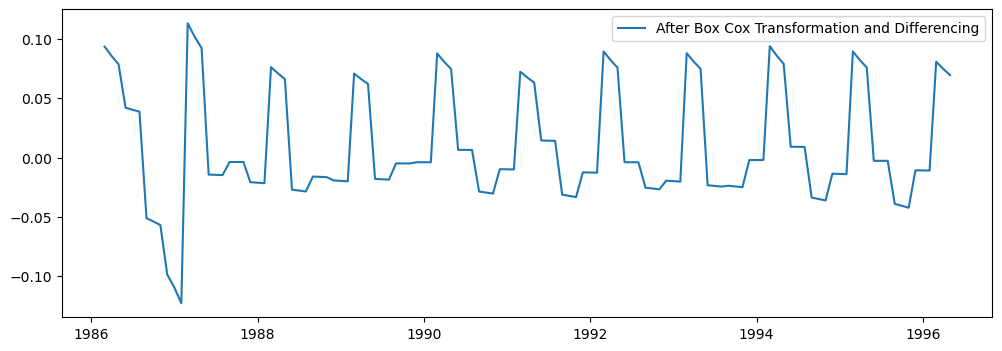

In [540]:
data_boxcox_diff = data_boxcox - data_boxcox.shift()
data_boxcox_diff.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox Transformation and Differencing')
plt.legend(loc='best')
plt.show()

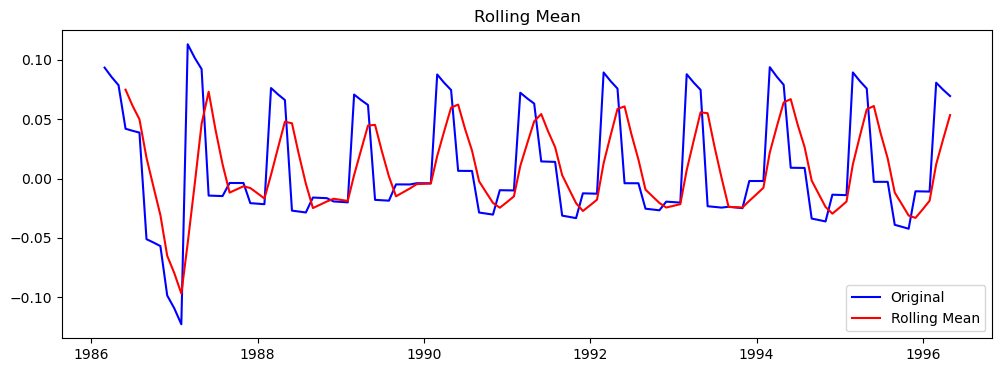

Results of Dickey Fuller Test:
Test Statistic                  -3.030060
p-value                          0.032181
#Lags Used                      12.000000
Number of Observations Used    110.000000
Critical Value (1%)             -3.491245
Critical Value (5%)             -2.888195
Critical Value (10%)            -2.580988
dtype: float64


In [541]:
plt.figure(figsize=(12,4))
test_stationarity(data_boxcox_diff)

In [542]:
adf_test(data_boxcox_diff.Sales)

Reject the null hypothesis
Data is stationary


#### Finally, Our Series is now stationary for AR Forecasting
### Building The Time Series Forecasting with Optimal Value using ARIMA

In [543]:
train_data_boxcox = data_boxcox[:100]
test_data_boxcox = data_boxcox[100:]
train_data_boxcox_diff = data_boxcox_diff[:99]
test_data_boxcox_diff = data_boxcox_diff[99:]

### ARIMA Hyperparameter Tuning

In [544]:
# Grid search ARIMA parameters for a time series
# Evaluate an ARIMA model for a given order (p,d,q) and return RMSE

def evaluate_arima_model(X, arima_order):

# Prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.70)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]

# Make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(timeout=300)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
        
# Calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

# Evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                except Exception as e:
                    print(e)
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

## Model Evaluation
### RMSE (Root Mean Squared Error)

In [545]:
rmse_arima = np.sqrt(mean_squared_error(test_data.Sales, y_hat_ar['arima_forecast'][test_data.index.min():])).round(2)
rmse_arima

476.52

### MAPE (Mean Absolute Percent Error)

In [546]:
mape_arima = round(np.mean(np.abs((test_data.Sales - y_hat_ar['arima_forecast'][test_data.index.min():])/test_data.Sales)*100),2)
mape_arima

8.91

### Analysing the Residuals
#### The mean of the Residual should be zero or close to Zero

In [547]:
model_residual = model_fit.resid
model_residual.mean()

0.037048699325853605

#### Residuals must be stationary

In [548]:
adf_test(model_residual)

Reject the null hypothesis
Data is stationary


#### No autocorrelation between residuals

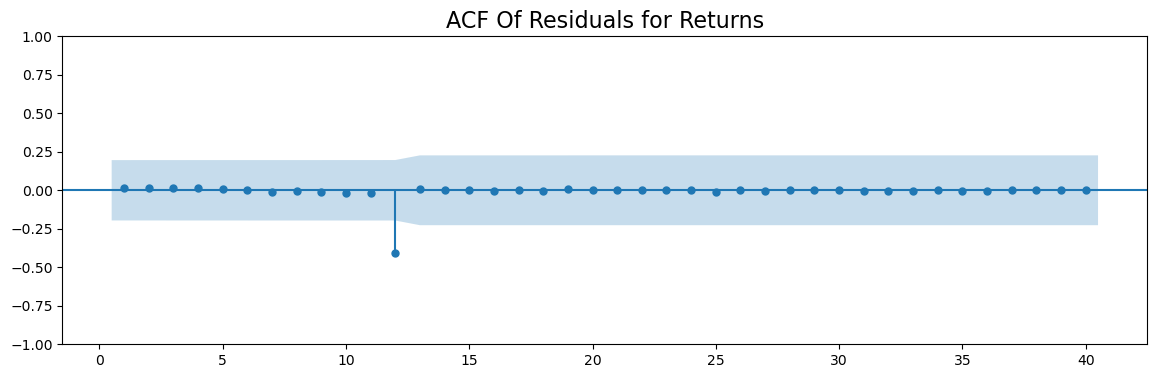

In [549]:
plt.rcParams["figure.figsize"] = (14,4)
plot_acf(model_residual, zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size=16)
plt.show()

#### Residuals must be random

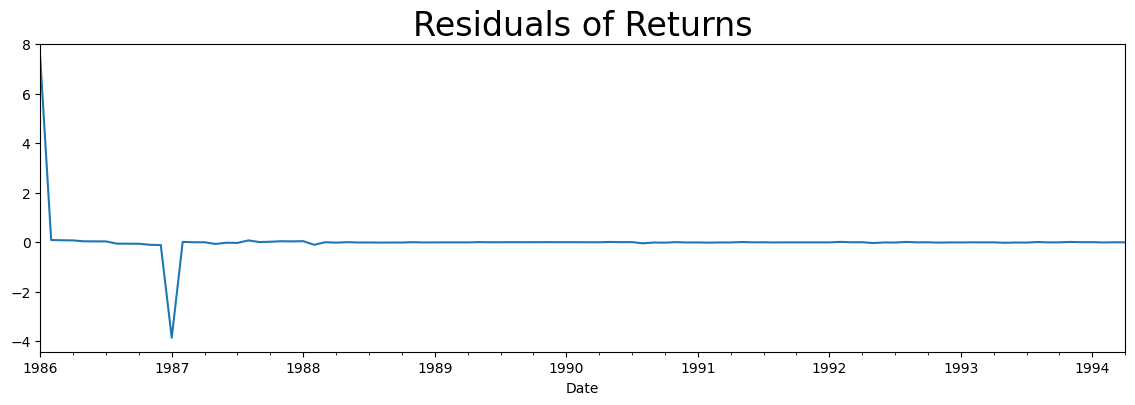

In [550]:
model_residual.plot(figsize=(14,4))
plt.title("Residuals of Returns", size=24)
plt.show()